## **Import the TensorFlow library**

This code contains a small script that is used for generating a folder full of images. The idea is to show these images to the OpenMV camera when the training with the OL methos is required. Since the idea is to apply a supervised training is required to have a ground truth forthe computation of the error that the model is doing. This script fills a directory with images of digits and creates a txt file in which all the labels are saved. 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import random 
import csv 
import sys
import os
import re
from random import seed

import time
#import os, os.path
import cv2
import glob
from keras import applications
#from keras.applications import vgg19
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

from numpy.ma.core import size

import torchvision.models as models
from torchvision import transforms
ROOT_PATH = os.path.abspath('')
sys.path.insert(0, ROOT_PATH + '/lib')

# VS Code

# IMPORT AND LOAD MODELS

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from sklearn.cluster import KMeans


import random 
from random import seed

import time


import numpy as np
import matplotlib.pyplot as plt

# Absolute path is needed to load libraries 
ROOT_PATH = os.path.abspath('')
sys.path.append(ROOT_PATH + '/lib')

# Test import
# from lib import simulation_lib
# from lib.simulation_lib import

# from lib import Kmeans_lib
from lib.active_lib import *
from lib.EvalMetrics import *


2022-10-27 23:43:06.632128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# LOAD DATASETS

In [2]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes from MNIST are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes from MNIST are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


In [3]:
n_samples = 500 # Gets doubled
digits_train = np.zeros((n_samples,28,28))
digits_test = np.zeros((n_samples,28,28))
label_digits_train = np.zeros(n_samples)
label_digits_test = np.zeros(n_samples)

for i in range(0, n_samples):
  n = random.randint(0,len(data_train)-1)
  digits_train[i,:,:] = data_train[n,:,:]
  label_digits_train[i] = label_train[n]
  m = random.randint(0,len(data_test)-1)
  digits_test[i,:,:] = np.copy(data_test[m,:,:])
  label_digits_test[i] = label_test[m]

img_rows, img_cols = 28, 28
digits_train  = digits_train.reshape(digits_train.shape[0], img_rows, img_cols, 1).astype(np.float32) / 255.0
digits_test = digits_test.reshape(digits_test.shape[0], img_rows, img_cols, 1).astype(np.float32) / 255.0
input_shape = (img_rows, img_cols, 1)

print(f'The dataset on which the model will be TRAINED has shape {digits_train.shape}') # da cambiare con il nuovo set
print(f'The dataset on which the model will be TESTED has shape  {digits_test.shape}') # da cambiare con il nuovo set

The dataset on which the model will be TRAINED has shape (500, 28, 28, 1)
The dataset on which the model will be TESTED has shape  (500, 28, 28, 1)


# TRAIN THE MODEL ON THE DIGITS 6-9 (OL METHOD)

In [12]:
def update_ll_OL(model, features, pseudolabel):
    learn_rate = model.l_rate
    
    CheckLabelKnown(model, pseudolabel)
    
    y_true_soft = DigitToSoftmax(pseudolabel, model.label)
               
    # Prediction
    y_pred = model.predict(features)
       
    # Backpropagation
    cost = y_pred-y_true_soft
        
    for j in range(0,model.W.shape[0]):
         # Update weights
        dW = np.multiply(cost, features[j]*learn_rate)
        model.W[j,:] = model.W[j,:]-dW

    # Update biases
    db      = np.multiply(cost, learn_rate)
    model.b = model.b-db






    prediction = np.argmax(y_pred)
    return prediction



def update_ll_CWR(model, features, pseudolabel):
    learn_rate = model.l_rate
    model_batch_size = model.batch_size

    # found_digit = np.zeros(10)  # reset
           
    CheckLabelKnown(model, pseudolabel)
    y_true_soft = DigitToSoftmax(pseudolabel, model.label)
        
    h = model.W.shape[0]
    w = model.W.shape[1] 

    # found_digit[np.argmax(y_true_soft)] += 1  # update the digit counter
            
    # PREDICTION

    y_pred_c = softmax(np.array(np.matmul(features, model.W) + model.b))      
    y_pred_t = softmax(np.array(np.matmul(features, model.W_2) + model.b_2)) 
 
    # BACKPROPAGATION
    cost = y_pred_t-y_true_soft

    # Update weights
    for j in range(0,h):
        deltaW = np.multiply(cost, features)
        dW = np.multiply(deltaW, learn_rate)
        model.W_2[j,:] = model.W_2[j,:] - dW

    # Update biases
    db = np.multiply(cost, learn_rate)
    model.b_2 = model.b_2-db
        
        
    # If beginning of batch
    #if(i%model_batch_size==0 and i!=0): 
    #    for k in range(0, w):
    #        if(found_digit[k]!=0):
    #            tempW = np.multiply(model.W[:,k], found_digit[k])
    #            tempB = np.multiply(model.b[k]  , found_digit[k])
    #            model.W[:,k] = np.multiply(tempW+model.W_2[:,k], 1/(found_digit[k]+1))
    #            model.b[k]   = np.multiply(tempB+model.b_2[k],   1/(found_digit[k]+1))
    #                
    #    model.W_2  =  np.copy(model.W) # np.zeros((model.W.shape)) 
    #    model.b_2  =  np.copy(model.b) # np.zeros((model.b.shape))       
    #    found_digit = np.zeros(10)  # reset

    prediction = np.argmax(y_pred_c)
    return prediction



def update_ll_OL_epoch(model, features, pseudo_labels, true_labels):

    err = 0
    predictions = []
    for i in range(0, len(pseudo_labels)):

        learn_rate = model.l_rate

        CheckLabelKnown(model, pseudo_labels[i])
    
        y_true_soft = DigitToSoftmax(pseudo_labels[i], model.label)
               
        # Prediction
        y_pred = model.predict(features[i,:])
        
        # Backpropagation
        cost = y_pred-y_true_soft
        
        for j in range(0,model.W.shape[0]):

            # Update weights
            dW = np.multiply(cost, features[i,j]*learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db      = np.multiply(cost, learn_rate)
        model.b = model.b-db
        
        # the next part is only to plot the confusion matrix
        # if the train data is finished still train the model but do not save the results
        if(i>=len(pseudo_labels)/2):

            y_true_soft = DigitToSoftmax(true_labels[i], model.label)
                   
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1  

        y_pred_amax = model.label[np.argmax(y_pred)]
        predictions.append(y_pred_amax)
        if(y_pred_amax != true_labels[i]):
            err += 1

    return predictions, err

In [13]:
def trainOneEpoch(model, images, labels, features_saved, labels_saved, batch_size, ll_ALGORITHM, verbose = False):

    n_cluster = 10
    n_samples = images.shape[0]

    clust_err_array = []
    model_err_array = []

    # BATCH PROCESSING OF DATA
    n_batch = int(np.ceil(n_samples / batch_size))
    images_batch = np.array_split(images, n_batch)
    labels_batch = np.array_split(labels, n_batch)

    err_clu = 0 # Clustering error (entire epoch)
    err_mod = 0 # Model error (entire epoch)
    # err_batch = np.zeros((n_batch,2))
    pseudolabels = []
    for i in range(0, n_batch):
        print("Starting batch: {}/{}".format(i+1, n_batch))
        # Features extraction
        start1 = time.time()
        features_batch = model.ML_frozen.predict(images_batch[i].reshape((batch_size,28,28,1)), verbose = False)
        end1 = time.time()

        # Kmean clustering
        start2 = time.time()
        pseudolabels_batch, err_clu_batch = k_mean_clustering(features_batch, features_saved, labels_batch[i], labels_saved, n_cluster, batch_size, verbose = False)
        end2 = time.time()
        pseudolabels.extend(pseudolabels_batch)
        # err_batch[i, :] = err, len(labels_batch)
        err_clu += err_clu_batch
        clust_err_array.append(err_clu_batch)

        # Layer update
    
        # SALVARE L'ARRAY DI PREDICTIONS
        
        #err_mod_batch = 0
        #for j in range(len(pseudolabels_batch)):
        #    if ll_ALGORITHM == 'OL':
        #        prediction = update_ll_OL(model, features_batch[j,:], pseudolabels_batch[j])
        #    if ll_ALGORITHM == 'CWR':
        #        prediction = update_ll_CWR(model, features_batch[j,:], pseudolabels_batch[j])

        #    if(prediction != labels_batch[i][j]):  
        #       err_mod_batch += 1
                # print("pred", prediction, "lab", labels_batch[i][j])

        #model_err_array.append(err_mod_batch)
        #err_mod += err_mod_batch

        if verbose:
            print("Features extraction took {:.3f} seconds and Kmean clustering took {:.3f} seconds, with {:.1%} accuracy ({} errors)".format(end1-start1, end2-start2, 1-err_clu_batch/batch_size, err_clu_batch))
            print("Batch Model errors {} ({:.1%} accuracy)".format(err_mod_batch, 1-err_mod_batch/batch_size))

    
    features = model.ML_frozen.predict(images, verbose = False) # Tmp recompute ---
    LL_predictions, err_mod = update_ll_OL_epoch(model, features, pseudolabels, labels)

    cmtx = confusion_matrix(LL_predictions, pseudolabels)

    split = int(n_samples/2)
    cmtx = confusion_matrix(LL_predictions[-split:-1], pseudolabels[-split:-1])
    print(cmtx)
    sumdiag = sum(cmtx[i][i] for i in range(10))
    print("diagonal:", sumdiag, "accuracy %:", round(100*sumdiag/split,2))
    

    print("Total clustering error: {:.1%} ({}/{} errors, {:.1%} accuracy)".format(err_clu/n_samples, err_clu, n_samples, 1-err_clu/n_samples))
    print("Total model error: {:.1%} ({}/{} errors, {:.1%} accuracy)".format(err_mod/n_samples, err_mod, n_samples, 1-err_mod/n_samples))

    return clust_err_array, model_err_array

In [14]:
# Options

n_feat = 10 # Select number of features
batch_size = 100 # Clustering batch size

MODEL_PATH = 'Models/{}/'.format(n_feat)
features_saved = np.loadtxt(MODEL_PATH + 'll_features.txt')
labels_features_saved = np.loadtxt(MODEL_PATH + 'll_labels_features.txt').astype(int)
model = keras.models.load_model(MODEL_PATH + 'original_mnist_cnn.h5') # Original model 

Model_OL = Custom_Layer(model)
Model_OL.title      = 'OL'
Model_OL.filename   = 'OL'
Model_OL.l_rate     = 0.01
Model_OL.batch_size = 8

digits = np.concatenate((digits_train, digits_test))   
labels = np.concatenate((label_digits_train, label_digits_test))  

ALGORITHM = 'OL'
# ALGORITHM = 'CWR'

start3 = time.time()
clust_err_array, model_err_array = trainOneEpoch(Model_OL, digits, labels, features_saved, labels_features_saved, batch_size, ALGORITHM)
end3 = time.time()

print("Elaboration time {:.3f}".format(end3-start3))

print(clust_err_array)
print(model_err_array)

Starting batch: 1/10
Starting batch: 2/10
Starting batch: 3/10
Starting batch: 4/10
Starting batch: 5/10
Starting batch: 6/10
Starting batch: 7/10
Starting batch: 8/10
Starting batch: 9/10
Starting batch: 10/10
New digit detected -> 7
New digit detected -> 8
New digit detected -> 9
New digit detected -> 6
[[50  0  0  0  0  0  2  0  0  0]
 [ 0 59  4  0  0  0  0  1  0  0]
 [ 0  2 46  0  0  0  0  2  1  1]
 [ 0  0  1 45  0  0  0  1  1  0]
 [ 0  0  0  0 39  0  2  0  0  7]
 [ 0  1  0  1  0 39  2  1  0  0]
 [ 0  0  0  0  0  2 37  0  2  2]
 [ 0  1  3  0  0  1  0 43  1  3]
 [ 0  2  1  1  0  0  0  0 37  2]
 [ 0  1  1  0  7  2  1  3  2 36]]
diagonal: 431 accuracy %: 86.2
Total clustering error: 14.2% (142/1000 errors, 85.8% accuracy)
Total model error: 13.1% (131/1000 errors, 86.9% accuracy)
Elaboration time 9.782
[17, 20, 20, 9, 18, 13, 8, 21, 11, 5]
[]


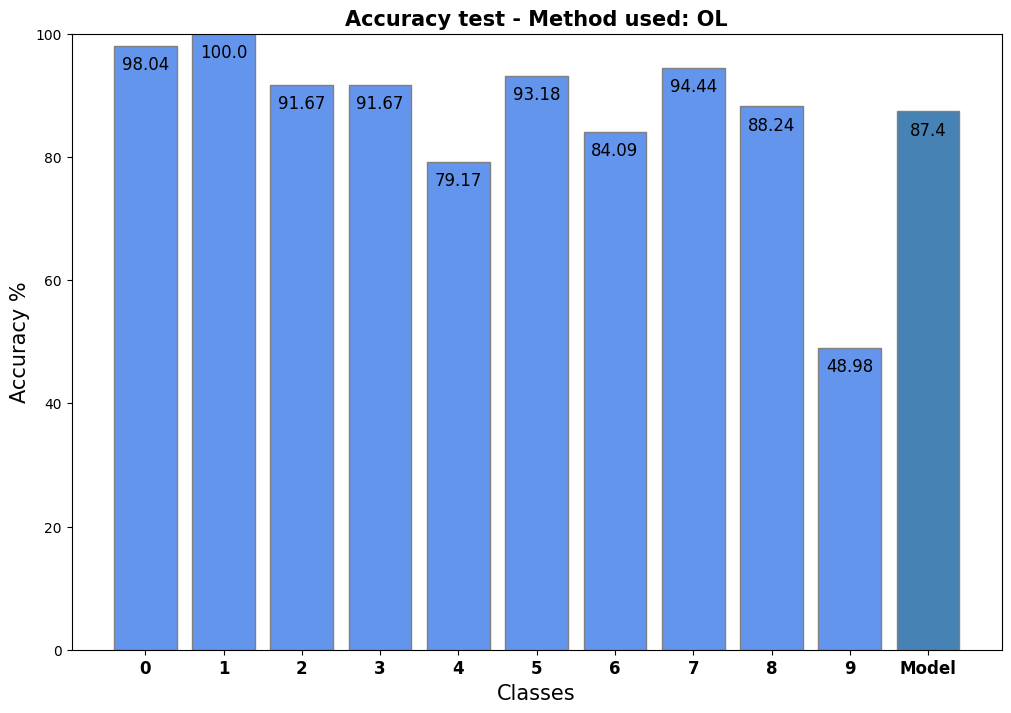

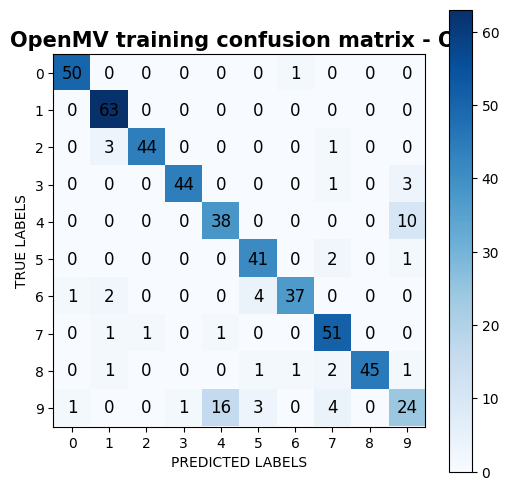

In [11]:
from simulation_lib import *


# IDEE METRICHE PER SIMULAZIONE 

plot_barChart(Model_OL)
plot_confMatrix(Model_OL)
#plot_table(Model_OL)

In [8]:
# Bar chart plot

""" Generates a bar plot of the class model given in input. The bar plot is generated from the attributo confusion_matrix """
def plot_barChart(model):
    
    conf_matr   = model.conf_matr
    title       = model.title 
    filename    = model.filename

    real_label = ['0','1','2','3','4','5','6','7','8','9','Model']
    # Generate matrix of colors for the bars
    blue2 = 'cornflowerblue'
    colors = [blue2, blue2, blue2, blue2, blue2, 
              blue2, blue2, blue2, blue2, blue2, 'steelblue']  

    bar_values   = np.zeros(conf_matr.shape[0]+1)
    tot_pred     = 0
    correct_pred = 0

    # Compute the accuracy for each label and store it inside array
    for i in range(0, conf_matr.shape[0]):
        if( sum(conf_matr[i,:]) != 0):
            bar_values[i] = round(round(conf_matr[i,i]/sum(conf_matr[i,:]),4)*100, 2)      # Accuracy for each letter
        tot_pred += sum(conf_matr[i,:])
        correct_pred += conf_matr[i,i]

    bar_values[-1] = round(round(correct_pred/tot_pred, 4)*100,2)   # Overall accuracy of the model
    
    fig = plt.subplots(figsize =(12, 8))
    bar_plot = plt.bar(real_label, bar_values, color=colors, edgecolor='grey')

    # Add text to each bar showing the percentage of accuracy
    for p in bar_plot:
        height = p.get_height()
        xy_pos = (p.get_x() + p.get_width() / 2, height)
        xy_txt = (0, -20) 

        # Avoid the text to be outside the image if bar is too low
        if(height>10):
            plt.annotate(str(height), xy=xy_pos, xytext=xy_txt, textcoords="offset points", ha='center', va='bottom', fontsize=12)
        else:
            plt.annotate(str(height), xy=xy_pos, xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)

    
    # Plot
    plt.ylim([0, 100])
    plt.ylabel('Accuracy %', fontsize = 15)
    plt.xlabel('Classes', fontsize = 15)
    plt.xticks([r for r in range(len(real_label))], real_label, fontweight ='bold', fontsize = 12) # Write on x axis the letter name
    plt.title('Accuracy test - Method used: '+title, fontweight ='bold', fontsize = 15)


In [9]:
#import importlib
#importlib.reload(Kmeans_lib)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"  







feat = features_saved[1,:]

##(features_saved.all)
#max(features_saved)

feat.dtype

np.amin(feat)
np.amax(feat)

feat.shape
feat

X = digits_train[1,:]
YY = Model_OL.ML_frozen.predict(X.reshape((1,28,28,1)), verbose = False)

# YY2 = np.array(YY as features_saved)

np.amin(YY)
np.amax(YY)

#from simulation_lib import *


# IDEE METRICHE PER SIMULAZIONE 

#plot_barChart(Model_OL)
#plot_confMatrix(Model_OL)
#plot_table(Model_OL)

# from lib import simulation_lib as sim_lib
# sim_lib.plot_barChart(Model_OL)
# sim_lib.plot_confMatrix(Model_OL)
# sim_lib.plot_table(Model_OL)

4.1544685

In [10]:
# OLD
def trainOneEpoch_CWR(model, images, labels, features_saved, labels_saved, batch_size, found_digit):
                 
    n_cluster = 10
    n_samples = images.shape[0]  #test_samples
     
    prediction_vec = np.zeros(test_samples) # non so se serve in CWR update


    # BATCH PROCESSING OF DATA
    n_batch = int(np.ceil(n_samples / batch_size))
    images_batch = np.array_split(images, n_batch)
    labels_batch = np.array_split(labels, n_batch)

    err_clu = 0                    
    err_mod = 0
    err_batch = np.zeros((n_batch,2))
    pseudo_labels = []

    for i in range(0, n_batch):
        print("Starting batch: {}/{}".format(i+1, n_batch))
        # Features extraction
        start1 = time.time()
        features_batch = model.ML_frozen.predict(images_batch[i].reshape((batch_size,28,28,1)), verbose = False)
        end1 = time.time()

        # Kmean clustering
        start2 = time.time()
        pseudo_labels_batch, err = k_mean_clustering(features_batch, features_saved, labels_batch[i], labels_saved, n_cluster, batch_size)
        end2 = time.time()
        pseudo_labels.extend(pseudo_labels_batch)
        err_batch[i, :] = err, len(labels_batch)
        err_clu += err

        ## Fino qui sopra CWR e OL sono praticamente uguali e quindi si potrebbero unire

        

        print("Features extraction took {:.3f} seconds and Kmean clustering took {:.3f} seconds, with {:.1%} accuracy ({} errors)".format(end1-start1, end2-start2, 1-err/batch_size, err))

    # ONLINE-LEARNING
    print('**********************************\nPerforming training CWR \n ')  
                   
    # Cycle over all input samples
    #for i in range(0, test_samples):

 
        
    # Metrics

    print('\n*******************************************************************************')
    print('***** Model batch accuracies: \n')
    
    ComputeEvalMetrics(y_test, prediction_vec, list(range(0, n_cluster)))

    
    return np.array(pseudo_labels).astype(int), prediction_vec, err_clu, err_mod